In [1]:
import os
import pandas as pd
import json
import requests
import logging
#import h5py
from urllib.parse import urlencode  # For Python 3

# Check if the log file already exists; if not, create it
log_file_path = 'catcher.log'
if not os.path.exists(log_file_path):
    open(log_file_path, 'a').close()  # Create an empty log file

# Configure logging to write to both console and file
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s: %(message)s',
    handlers=[
        logging.StreamHandler(),  # Log to console
        logging.FileHandler(log_file_path)  # Log to file
    ]
)

# Create the 'data2' directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# Configure logging to write to both console and file
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# ... (logging handlers configuration remains the same)

url = 'http://aws.okx.com'
history_candles_base = '/api/v5/market/history-candles?instId=BTC-USDT-SWAP&bar=1Dutc'

store = pd.HDFStore('data/catcher.h5', 'w')

try:
    df = store['a0']
except KeyError:  # If 'data2' key does not exist in HDF5 filedf = df.sort_values(by='ts')
    df = pd.DataFrame()
    pass
try:
    df.rename(columns={'open': 'Open','high': 'High', 'low':'Low', 'close':'Close','volume': 'Volume'}, inplace=True)
except KeyError:
    print("One or more columns specified for renaming were not found in the DataFrame.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Continue with your code assuming df is now either loaded or initialized as empty

after_value = df.iloc[-1, 0] if not df.empty else None
before_value = df.iloc[0, 0] if not df.empty else None

# Convert columns to numeric or string
#for col in ['ts', 'Open', 'High', 'Low', 'Close','Volume', 'volCcy', 'volCcyQuote','confirm']:
#    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(str)
        
def fetch_and_append_data(after=None):
    logger.info('ftch_and_append_data()')
    params = {}
    if after:
        params['after'] = after

    history_candles_url = f"{url}{history_candles_base}&{urlencode(params)}"

    logger.info(f"Sending request to {history_candles_url}")

    response = requests.get(history_candles_url)
    response_json = json.loads(response.text)

    # Assuming 'data' key contains the actual candlestick data with the expected column names
    new_df = pd.DataFrame(response_json['data'], columns=['ts', 'Open', 'High', 'Low', 'Close','Volume', 'volCcy', 'volCcyQuote', 'confirm'])
    
    if new_df.empty:
        return
    
    # Make sure the 'ts' column is converted to numeric if possible, else convert it to string
    new_df['ts'] = pd.to_numeric(new_df['ts'], errors='coerce')

    global df
    
    # Check for next page (pagination) based on the length of the new data batch
    if len(new_df) >= 100:  # Assuming each batch returns at least 100 rows
        df = pd.concat([df, new_df], axis=0).reset_index(drop=True)  # Append new_df to df first

        # Save DataFrame to HDF5
        logger.info("Saving DataFrame to HDF5 file...")
        store.put('a0', df, format='table')
        logger.info("DataFrame saved successfully.")

        after_value = new_df.iloc[-1, 0]  # Get the timestamp of the last row in the new batch
        fetch_and_append_data(after=after_value)

    else:  # If the new batch has less than 100 rows (assuming this indicates the end of pagination)
        df = pd.concat([df, new_df], axis=0).reset_index(drop=True)  # Append new_df to df even if it's the last batch

        # Convert columns to numeric or string
        for col in ['ts', 'Open', 'High', 'Low', 'Close', 'Volume', 'volCcy', 'volCcyQuote', 'confirm']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Save DataFrame to HDF5
        logger.info("Saving DataFrame to HDF5 file...")
        store.put('a0', df, format='table')
        logger.info("DataFrame saved successfully.")

        # If there are no more pages or the last page had less than 100 rows, save the final DataFrame
        df = df.apply(pd.to_numeric, errors='coerce')
        # Jump out of the function
        return df



def update(before=None):
    logger.info('update()')
    params = {}
    if before:
        params['before'] = before

    history_candles_url = f"{url}{history_candles_base}&{urlencode(params)}"

    logger.info(f"Sending request to {history_candles_url}")

    response = requests.get(history_candles_url)
    response_json = json.loads(response.text)

    # Assuming 'data' key contains the actual candlestick data with the expected column names
    new_df = pd.DataFrame(response_json['data'], columns=['ts', 'Open', 'High', 'Low', 'Close','Volume', 'volCcy', 'volCcyQuote','confirm'])
    
    # Make sure the 'ts' column is converted to numeric if possible, else convert it to string
    new_df['ts'] = pd.to_numeric(new_df['ts'], errors='coerce')
    
    # If there's no new data, stop fetching
    if new_df.empty:
        return
    
    global df
    
    # Check for next page (pagination) based on the length of the new data batch
    if len(new_df) >= 100:  # Assuming each batch returns at least 100 rows
        df = pd.concat([new_df, df], axis=0).reset_index(drop=True)  # Append new_df to df first
        df = df.apply(pd.to_numeric, errors='coerce')
        # Save DataFrame to HDF5
        logger.info("Saving DataFrame to HDF5 file...")
        store.put('a0', df, format='table')
        logger.info("DataFrame saved successfully.")

        before_value = new_df.iloc[0, 0]  # Get the timestamp of the last row in the new batch
        update(before=before_value)

    else:  # If the new batch has less than 100 rows (assuming this indicates the end of pagination)
        df = pd.concat([new_df, df], axis=0).reset_index(drop=True)  # Append new_df to df even if it's the last batch

        # Convert columns to numeric or string
        for col in ['ts', 'Open', 'High', 'Low', 'Close', 'Volume', 'volCcy', 'volCcyQuote', 'confirm']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Save DataFrame to HDF5
        logger.info("Saving DataFrame to HDF5 file...")
        store.put('a0', df, format='table')
        logger.info("DataFrame saved successfully.")

        # If there are no more pages or the last page had less than 100 rows, save the final DataFrame

        # Jump out of the function
        return df

fetch_and_append_data(after_value)

before_value = df.iloc[0, 0] if not df.empty else None
update(before_value) 

store.close()

# Assuming your DataFrame is loaded with 'ts' column in milliseconds
df['datetime'] = pd.to_datetime(df['ts'], unit='ms')  # Convert timestamps to datetime (ignore the FutureWarning for now)
df.set_index('datetime', inplace=True)  # Set datetime as the index for time series operations
df['weekday'] = df.index.weekday  # Weekday: Monday=0, Tuesday=1, ..., Sunday=6
# Optionally add other time-related features:
df['day'] = df.index.day
df = df.drop(columns = ['confirm'])
# Instead of reopening an existing store, create a new one with the desired filename
new_store_filename = './data//catcher.h5'
store = pd.HDFStore(new_store_filename)

logging.info("Saving DataFrame with preload to new HDF5 file...")
store.put('a1', df, format='table')

# Don't forget to close the store after saving
store.close()

# Logging that the script has finished execution
logger.info(f"Script execution completed. DataFrame shape: {df.shape}")

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


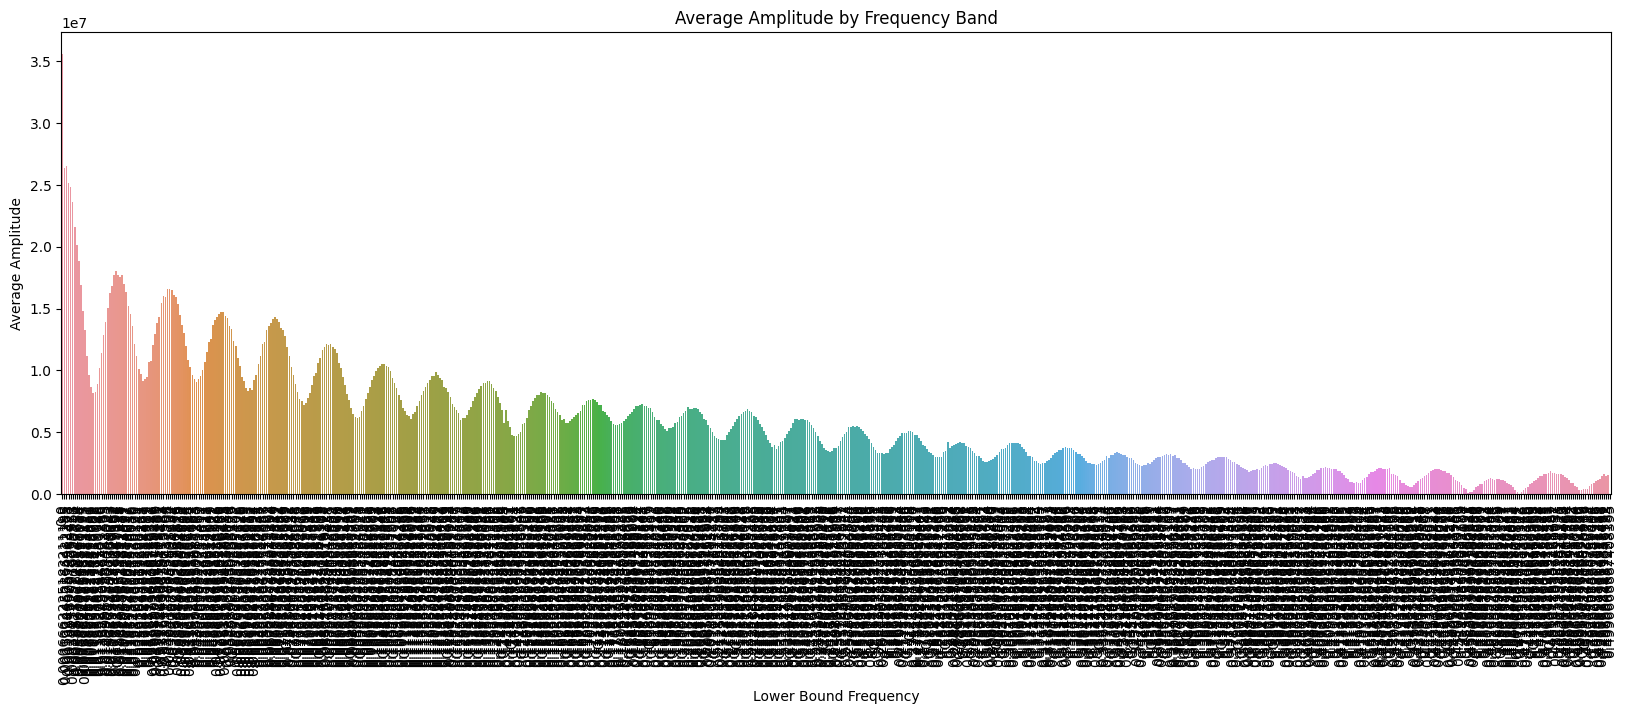

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


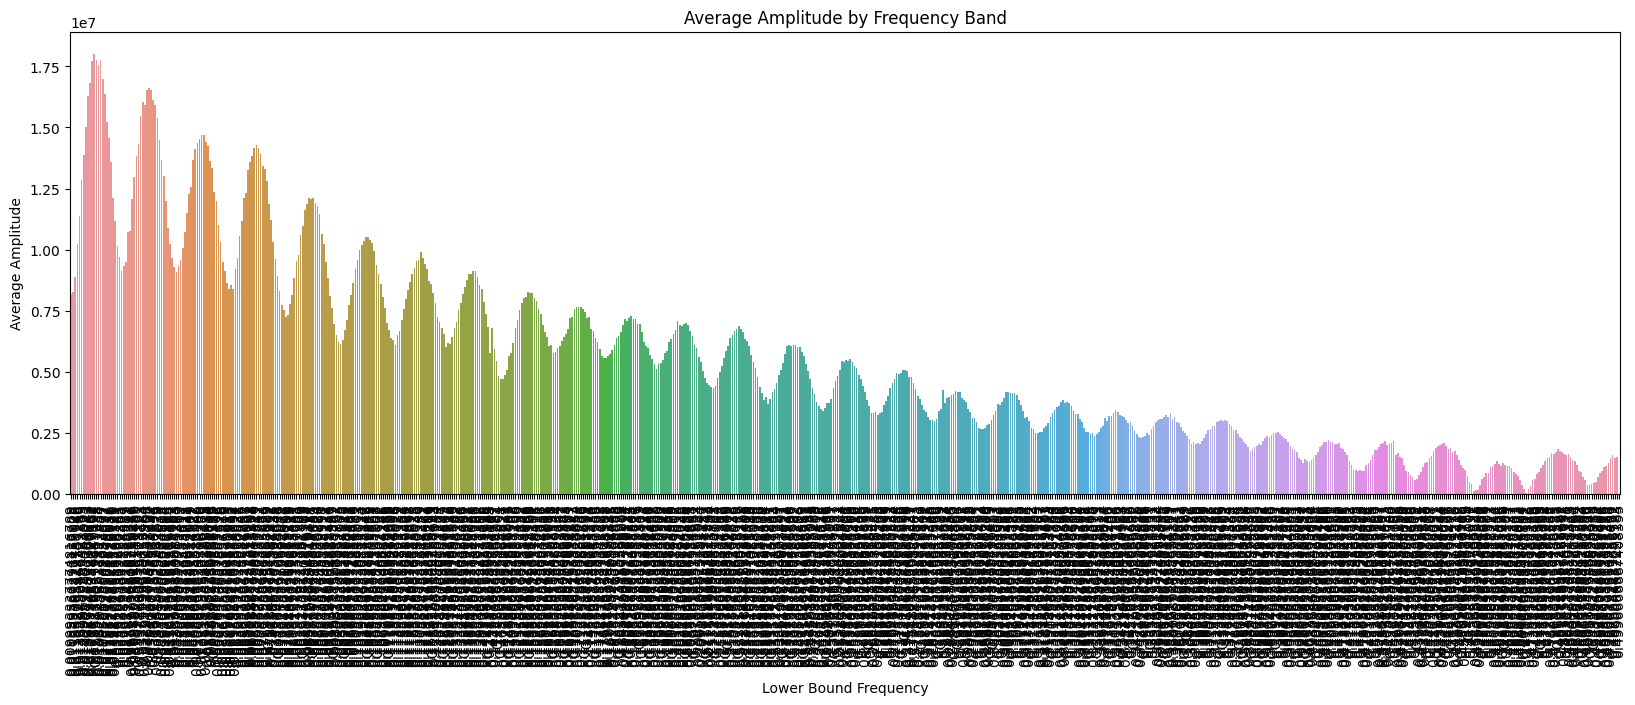

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


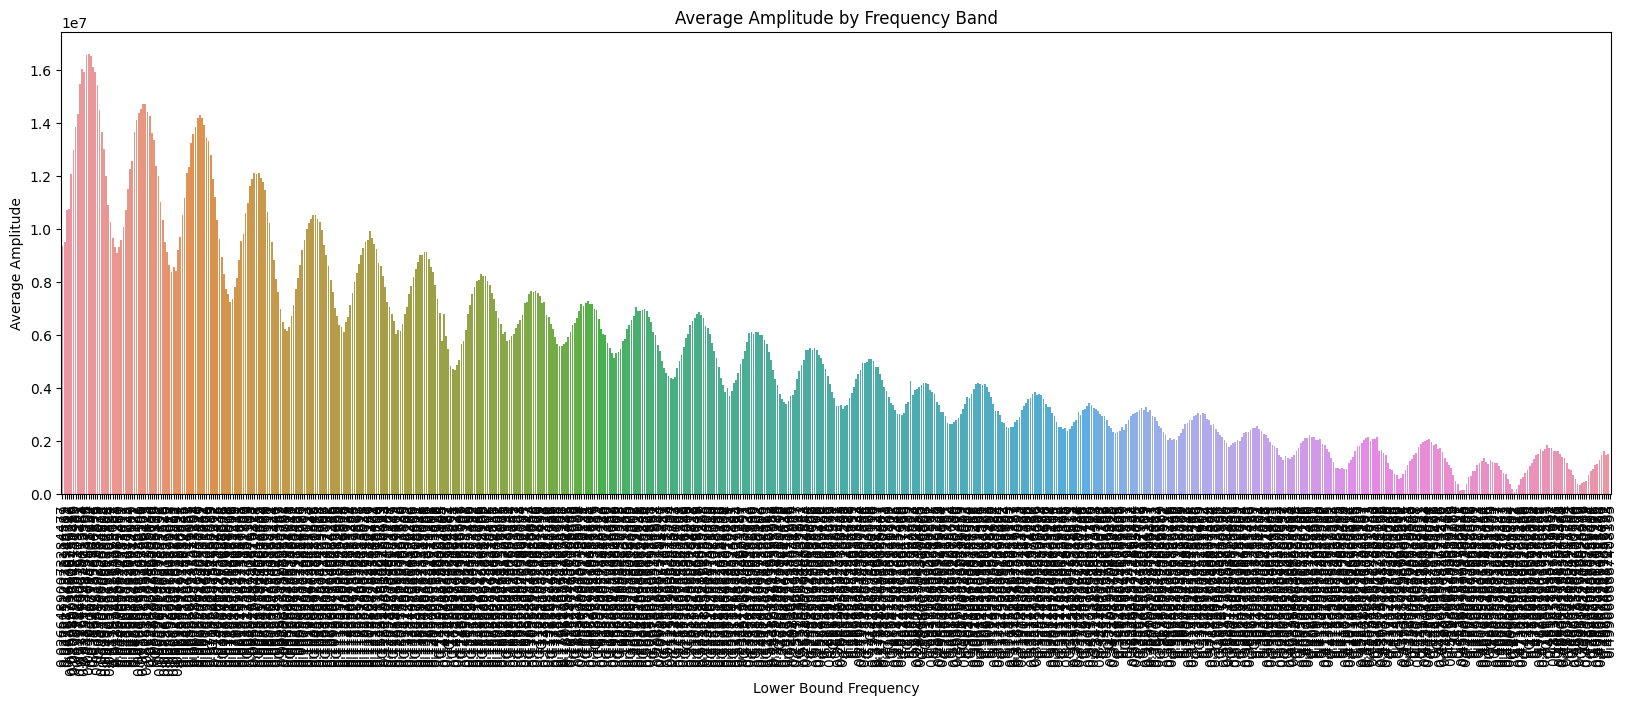

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import logging

#Check if the log file already exists; if not, create it
log_file_path = 'loader.log'
if not os.path.exists(log_file_path):
    open(log_file_path, 'a').close()  # Create an empty log file

# Configure logging to write to both console and file
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s: %(message)s',
    handlers=[
        logging.StreamHandler(),  # Log to console
        logging.FileHandler(log_file_path)  # Log to file
    ]
)


# Configure logging to write to both console and file
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

store = pd.HDFStore('./data/catcher.h5', 'r')
df = store['a1']

store.close()

try:
    df.rename(columns={'open': 'Open','high': 'High', 'low':'Low', 'close':'Close','volume': 'Volume'}, inplace=True)
except KeyError:
    print("One or more columns specified for renaming were not found in the DataFrame.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    
# Assuming df['close'] contains the closing prices
data = df['Volume'].values

def get_fft_data(skip):

    N = len(data)
    sampling_freq = 1  # This should be set according to your data sampling frequency
    freqs = np.fft.fftfreq(N, d=1/sampling_freq)

    spectrum = np.fft.fft(data)

    # If you need the real part only (for magnitude spectrum)
    real_part = np.abs(spectrum[:N//2])

    # Or if you're interested in amplitude spectrum
    amplitude_spectrum = np.abs(spectrum)/N

    # Since we only need positive frequencies for real signals  
    freqs_positive = freqs[:N//2]

    # Find the index of the maximum amplitude_spectrum excluding 0
    #max_index = np.argmax(amplitude_spectrum[1:]) + 1  # We add 1 because we skip the first element

    # Assuming your sampling_freq is correct
    band_width = 1  # Define the width of each band in terms of days (or whatever units your index represents)
    band_width_days = band_width  # Keep the original band width in days
    band_width_hz = band_width_days * sampling_freq / N  # Convert band width from days to Hz

    # Calculate the number of bands by rounding up to the nearest integer
    num_bands = int(np.ceil((sampling_freq / 2) / band_width_hz))

    # Create frequency bands based on your desired interval (e.g., if you want intervals of band_width_hz)
    bands = [(i * band_width_hz, min((i + 1) * band_width_hz, sampling_freq / 2)) 
         for i in range(0, num_bands)]

    amplitude_by_band = {}

    for lower_freq_hz, upper_freq_hz in bands:
        # Ensure the bounds do not exceed the Nyquist frequency
        lower_freq_index = np.searchsorted(freqs_positive, lower_freq_hz)
        upper_freq_index = np.searchsorted(freqs_positive, upper_freq_hz)

        if upper_freq_index > N//2:  # For real signals, we only need the first half of the spectrum
            upper_freq_index = N//2

        band_amplitudes = amplitude_spectrum[lower_freq_index:upper_freq_index]
    
        avg_amplitude = np.mean(band_amplitudes)
        amplitude_by_band[(lower_freq_hz, upper_freq_hz)] = avg_amplitude

    # Create a DataFrame from the amplitude_by_band dictionary
    df_amplitudes = pd.DataFrame.from_dict(amplitude_by_band, orient='index', columns=['Average Amplitude'])

    # Rename the index to 'Frequency Band'
    df_amplitudes.index.names = ['Frequency Band']

    # Convert the index to a separate column
    df_amplitudes.reset_index(inplace=True)

    # Split the 'Frequency Band' into two separate columns 'Lower Bound' and 'Upper Bound'
    df_amplitudes[['Lower Bound', 'Upper Bound']] = df_amplitudes['Frequency Band'].apply(pd.Series)

    # Remove the old 'Frequency Band' column
    df_amplitudes.drop(columns=['Frequency Band'], inplace=True)
    df_amplitudes=df_amplitudes[skip:]

     
    # Plotting with Seaborn (using barplot for example)
    plt.figure(figsize=(20, 6))
    sns.barplot(x='Lower Bound', y='Average Amplitude', data=df_amplitudes)
    plt.xlabel('Lower Bound Frequency')
    plt.ylabel('Average Amplitude')
    plt.title('Average Amplitude by Frequency Band')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.show()
     

    # Find the index of the row with the maximum 'Average Amplitude'
    i = df_amplitudes['Average Amplitude'].idxmax()

    # Retrieve the lower and upper bounds for that row
    Lower = df_amplitudes.loc[i, 'Lower Bound']
    Upper = df_amplitudes.loc[i, 'Upper Bound']

    # If you want to multiply these bounds by the length of the original DataFrame (df), do so:
    Lower = Lower* N
    Upper = Upper* N

    if (Lower - int(Lower)) >= 0.5:
        Lower = int(Lower) + 1
    else:
        Lower = int(Lower)
	
    if (Upper - int(Upper)) >= 0.5:
        Upper = int(Upper) + 1
    else:
        Upper = int(Upper)

    return Lower, Upper

skip = [0, 15, 40]
fast_Lower, fast_Upper = get_fft_data(skip[0])
logging.info(f'fast_Lower: {fast_Lower}   fast_Upper:{fast_Upper}')

length_Lower, length_Upper = get_fft_data(skip[1])
logging.info(f'length_Lower: {length_Lower}   length_Upper:{length_Upper}')

slow_Lower, slow_Upper = get_fft_data(skip[2])
logging.info(f'slow_Lower: {slow_Lower}   slow_Upper:{slow_Upper}')


In [3]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=99ca9c47ef8e1c73f2ba9f2f49a53c5a0fff186058f92253be6b59865ab8294d
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [4]:


import numpy as np
import pandas as pd
import pandas_ta as ta
import h5py
import warnings
from sklearn.utils import compute_class_weight
import numpy as np
import pandas as pd
#import gc
from sklearn.cluster import KMeans



warnings.filterwarnings('ignore', category = FutureWarning)
warnings.filterwarnings('ignore', category = RuntimeWarning)

store = pd.HDFStore('data/catcher.h5', 'r')
df = store['a1']
store.close()
df = df.sort_values(by='ts')


# Assuming n_clusters is the number of clusters you want
n_clusters = 3

# Initialize the KMeans model
kmeans = KMeans(n_clusters=n_clusters)
# target drop
df['N_C'] = df['Close'].shift(-1)
df['N_H'] = df['High'].shift(-1)
df['N_L'] = df['Low'].shift(-1)
df['N_V'] = df['Volume'].shift(-1)


df = df.apply(pd.to_numeric, errors='coerce')


# define target  
df['tarPer_C'] = (df['N_C'] - df['Close'])/ df['Close']
df['tarPer_H'] = (df['N_H'] - df['Close']) / df['Close']
df['tarPer_L']= (df['N_L'] - df['Close']) / df['Close']
df['tarPer_V']= (df['N_V'] - df['Volume']) / df['Volume']

# drop furtue index
df = df.drop(columns=['N_C', 'N_H', 'N_L', 'N_V'])


df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
# High-Low midpoint (HL2)
df['HL2']=(df['High']+df['Low']) / 2


# Typical Price (HLC3)
df.ta.hlc3(offset=None)

# Volume Weighted Average Price (VWAP)
df.ta.vwap(anchor=None, offset=None, append=True)


# Weighted Close Price (WCP)
df.ta.wcp(offset=None, append=True)


df['ML'] = df['High'] - df["Low"]
df['PV_ML'] = df['ML'] / df['Volume']
df['BDL'] = df['Close'] - df['Low']
df['AKL'] = df['High'] - df['Close']
df['PV_BDL'] = df['BDL'] / df['Volume']
df['PV_AKL'] = df['AKL'] / df['Volume']
df['bull_l'] = df['BDL'] - df['AKL']
df['divbull_l'] = df['BDL'] / df['AKL']


df['PS_AKL'] = df['AKL'] / df['ML']


df['bullrock'] = df['Close'] - df['Open']
df['SA'] = df['ML'] - df['bullrock']
df['max_bull_zone'] = df[['Close', 'Open']].sub(df['Low'], axis=0).max(axis=1)
df['up_SA'] = df['ML'] - df['max_bull_zone']
df['low_SA'] = df['max_bull_zone'] - abs(df['bullrock'])
df['subUL'] = df['up_SA'] - df['low_SA']
df['divUL'] = df['up_SA'] / df['low_SA']
df['posLM'] = df['max_bull_zone'] / df['ML']
df['pos_low_SA'] = df['low_SA']/ df['ML']
df['pos_bullrock'] = df['bullrock']/ +df['ML']
df['PVLM'] = df['max_bull_zone'] / df['Volume']
df['PV_up_SA'] = df['up_SA'] / (  df['Volume'])
df['PV_low_SA'] = df['low_SA']/ (  df['Volume'])
df['PV_bullrock'] = df['bullrock']/ (  df['Volume'])
df['PV_SA'] = df['SA']/ (  df['Volume'])


len_c = len(df['Close'])
df['C_r'] = df['Close'].rank(ascending=False) / len_c
df['H_r'] = df['High'].rank(ascending=False) / len_c
df['L_r'] = df['Low'].rank(ascending=False) / len_c
df['V_r'] = df['Volume'].rank(ascending=False) / len_c

df['W_r'] = df['VWAP_D'].rank(ascending=False) / len_c

bounds_list = [length_Upper, slow_Upper, fast_Upper]
    
for length_ in bounds_list:

    df['L_C'+str(length_)] = df['Close'].shift(length_)
    df['L_H'+str(length_)] = df['High'].shift(length_)
    df['L_L'+str(length_)] = df['Low'].shift(length_)
    df['L_V'+str(length_)] = df['Volume'].shift(length_)
    df['L_O'+str(length_)] = df['Open'].shift(length_)

    df['L_C'+str(length_)] = df['L_C'+str(length_)].fillna(0)
    df['L_O'+str(length_)] = df['L_O'+str(length_)].fillna(0)
    df['L_L'+str(length_)] = df['L_L'+str(length_)].fillna(0)    

    df['amihud'+str(length_)] = (2*(df['L_H'+str(length_)] - df['L_L'+str(length_)]) - abs(df['L_O'+str(length_)] - df['L_C'+str(length_)])) / df['L_V'+str(length_)]

    df['ADClose'+str(length_)] = df['Close'] - df['L_C'+str(length_)]
    df['ADHigh'+str(length_)] = df['High'] - df['L_H'+str(length_)]
    df['ADLow'+str(length_)] = df['Low'] - df['L_L'+str(length_)]
    df['ADVolume'+str(length_)] = df['Volume'] - df['L_V'+str(length_)]

    df['PV_ADClose'+str(length_)] = df['ADClose'+str(length_)] / (  df['L_V'+str(length_)] )
    df['PV_ADHigh'+str(length_)] = df['ADHigh'+str(length_)] / (  df['L_V'+str(length_)] )
    df['PV_Low'+str(length_)] = df['ADLow'+str(length_)] / (  df['L_V'+str(length_)] )

    df['divClose'+str(length_)] = df['Close'] / (  df['L_C'+str(length_)])
    df['divHigh'+str(length_)] = df['High'] / (  df['L_H'+str(length_)])
    df['divLow'+str(length_)] = df['Low'] / (  df['L_L'+str(length_)])
    df['divVolume'+str(length_)] = df['Volume'] / (  df['L_V'+str(length_)]    )

    df['DELow'+str(length_)] = df['ADLow'+str(length_)] / (  df['L_L'+str(length_)])
    df['ML'+str(length_)]  = df['L_H'+str(length_)] - df['L_L'+str(length_)] 
    df['PV_ML' +str(length_)]= df['ML'+str(length_)]  / (  df['L_V'+str(length_)] )
    df['BDL'+str(length_)] = df['L_C'+str(length_)]- df['L_L'+str(length_)] 
    df['AKL'+str(length_)] = df['L_H'+str(length_)]- df['L_C'+str(length_)]
    df['PV_BDL'+str(length_)]= df['BDL'+str(length_)] / (  df['L_V'+str(length_)] )
    df['PV_AKL'+str(length_)] = df['AKL'+str(length_)] / (  df['L_V'+str(length_)] )
    df['bull_l'+str(length_)] = df['BDL'+str(length_)] - df['AKL'+str(length_)]
    df['divbull_l'+str(length_)] = df['BDL'+str(length_)] / (  df['AKL'+str(length_)])
    df['PS_AKL'+str(length_)] = df['AKL'+str(length_)] / (  df['ML'+str(length_)] )
    df['bullrock'+str(length_)] = df['L_C'+str(length_)]- df['L_O'+str(length_)]
    df['SA'+str(length_)] = df['ML'+str(length_)]  - df['bullrock'+str(length_)]

    df['max_bull_zone'+str(length_)] = np.where(df['bullrock'+str(length_)] >= 0,
                                          df['L_C'+str(length_)] - df['L_L'+str(length_)],
                                          df['L_O'+str(length_)] - df['L_L'+str(length_)])

    df['up_SA'+str(length_)] = df['ML'+str(length_)]  - df['max_bull_zone'+str(length_)]
    df['low_SA'+str(length_)] = df['max_bull_zone'+str(length_)] - abs(df['bullrock'+str(length_)])

    df['subUL' ] = df['up_SA'+ str(length_) ] - df['low_SA'+ str(length_) ]
    df['divUL'+ str(length_) ] = df['up_SA'+ str(length_) ] / (  df['low_SA'+ str(length_) ])

    df['posLM'+str(length_)] = df['max_bull_zone'+str(length_)] / (  df['ML'+str(length_)] )
    df['pos_up_SA'+str(length_)] = df['up_SA'+str(length_)] / (  df['ML'+str(length_)] )
    df['pos_low_SA'+str(length_)] = df['low_SA'+str(length_)]/ (  df['ML'+str(length_)] )
    df['pos_bullrock'+str(length_)] = df['bullrock'+str(length_)]/ (  df['ML'+str(length_)] )
    df['pos_SA'+str(length_)] = df['SA'+str(length_)]/ (  df['ML'+str(length_)] )

    df['PVLM'+str(length_)] = df['max_bull_zone'+str(length_)] / (  df['L_V'+str(length_)] )
    df['PV_up_SA'+str(length_)] = df['up_SA'+str(length_)] / (  df['L_V'+str(length_)] )
    df['PV_low_SA'+str(length_)] = df['low_SA'+str(length_)]/ (  df['L_V'+str(length_)] )
    df['PV_bullrock'+str(length_)] = df['bullrock'+str(length_)]/ (  df['L_V'+str(length_)] )
    df['PV_SA'+str(length_)] = df['SA'+str(length_)]/ (  df['L_V'+str(length_)] )

    # sub

    df['sub0ML'+str(length_)]  = df['ML'] - df['ML'+str(length_)] 
    df['sub0PV_ML' +str(length_)]=  df['PV_ML'] - df['PV_ML' +str(length_)]
    df['sub0BDL'+str(length_)] = df['BDL'] - df['BDL'+str(length_)]  
    df['sub0AKL'+str(length_)] = df['AKL'] - df['AKL'+str(length_)] 
    df['sub0PV_BDL'+str(length_)] = df['PV_BDL'] - df['PV_BDL'+str(length_)] 
    df['sub0PV_AKL'+str(length_)] = df['PV_AKL'] - df['PV_AKL'+str(length_)] 
    df['sub0bull_l'+str(length_)] = df['bull_l'] - df['bull_l'+str(length_)] 
    df['sub0divbull_l'+str(length_)] = df['divbull_l'] - df['divbull_l'+str(length_)] 

    #df['sub0logbull_l'+str(length_)] = df['logbull_l'] - df['logbull_l'+str(length_)] 
    #df['sub0PS_BDL'+str(length_)] = df['PS_BDL'] - df['PS_BDL'+str(length_)] 

    df['sub0bullrock'+str(length_)] = df['bullrock'] - df['bullrock'+str(length_)] 
    df['sub0SA'+str(length_)] = df['SA'] - df['SA'+str(length_)]  
    df['sub_fuLM'+str(length_)] = df['max_bull_zone'] - df['max_bull_zone'+str(length_)] 
    df['sub0up_SA'+str(length_)] = df['up_SA'] - df['up_SA'+str(length_)] 
    df['sub0low_SA'+str(length_)] = df['low_SA'] - df['low_SA'+str(length_)] 

    df['sub0posLM'+str(length_)] = df['posLM'] - df['posLM'+str(length_)] 
    #df['sub0pos_up_SA'+str(length_)] = df['pos_up_SA'] - df['pos_up_SA'+str(length_)] 
    df['sub0pos_low_SA'+str(length_)] = df['pos_low_SA'] - df['pos_low_SA'+str(length_)] 
    df['sub0pos_bullrock'+str(length_)] = df['pos_bullrock'] - df['pos_bullrock'+str(length_)] 

    df['sub0PVLM'+str(length_)] = df['PVLM'] - df['PVLM'+str(length_)] 
    df['sub0PV_up_SA'+str(length_)] = df['PV_up_SA'] - df['PV_up_SA'+str(length_)]  
    df['sub0PV_low_SA'+str(length_)] = df['PV_low_SA'] - df['PV_low_SA'+str(length_)] 
    df['sub0PV_bullrock'+str(length_)] = df['PV_bullrock'] - df['PV_bullrock'+str(length_)] 
    df['sub0PV_SA'+str(length_)] = df['PV_SA'] - df['PV_SA'+str(length_)] 

    # div

    df['div0ML'+str(length_)]  = df['ML'] / (  df['ML'+str(length_)] )
    df['div0PV_ML' +str(length_)]=  df['PV_ML'] / (  df['PV_ML' +str(length_)])
    df['div0BDL'+str(length_)] = df['BDL'] / (  df['BDL'+str(length_)]  )
    df['div0AKL'+str(length_)] = df['AKL'] / (  df['AKL'+str(length_)] )
    df['div0PV_BDL'+str(length_)] = df['PV_BDL'] / (  df['PV_BDL'+str(length_)] )
    df['div0PV_AKL'+str(length_)] = df['PV_AKL'] / (  df['PV_AKL'+str(length_)] )
    df['div0bull_l'+str(length_)] = df['bull_l'] / (  df['bull_l'+str(length_)] )

    #df['div0logbull_l'+str(length_)] = df['logbull_l'] / (  df['logbull_l'+str(length_)] )
    #df['div0PS_BDL'+str(length_)] = df['PS_BDL'] / (  df['PS_BDL'+str(length_)] )
    df['div0PS_AKL'+str(length_)] = df['PS_AKL'] / (  df['PS_AKL'+str(length_)] )
    #df['div0PS_bull_l'+str(length_)] = df['PS_bull_l'] / (  df['PS_bull_l'+str(length_)] )

    df['div0bullrock'+str(length_)] = df['bullrock'] / (  df['bullrock'+str(length_)] )
    df['div0SA'+str(length_)] = df['SA'] / (  df['SA'+str(length_)]  )
    df['div_fuLM'+str(length_)] = df['max_bull_zone'] / (  df['max_bull_zone'+str(length_)] )
    df['div0low_SA'+str(length_)] = df['low_SA'] / (  df['low_SA'+str(length_)] )

    #df['div0pos_up_SA'+str(length_)] = df['pos_up_SA'] / (  df['pos_up_SA'+str(length_)] )
    df['div0pos_low_SA'+str(length_)] = df['pos_low_SA'] / (  df['pos_low_SA'+str(length_)] )
    df['div0pos_bullrock'+str(length_)] = df['pos_bullrock'] / (  df['pos_bullrock'+str(length_)] )
    #df['div0pos_SA'+str(length_)] = df['pos_SA'] / (  df['pos_SA'+str(length_)]  )

    df['div0PVLM'+str(length_)] = df['PVLM'] / (  df['PVLM'+str(length_)] )
    df['div0PV_up_SA'+str(length_)] = df['PV_up_SA'] / (  df['PV_up_SA'+str(length_)]  )
    df['div0PV_low_SA'+str(length_)] = df['PV_low_SA'] / (  df['PV_low_SA'+str(length_)] )
    df['div0PV_bullrock'+str(length_)] = df['PV_bullrock'] / (  df['PV_bullrock'+str(length_)] )
    df['div0PV_SA'+str(length_)] = df['PV_SA'] / (  df['PV_SA'+str(length_)] )

    # log

    df['log0PV_BDL'+str(length_)] = np.log(abs(df['PV_BDL'] ))- np.log(abs(df['PV_BDL'+str(length_)] ))
    df['log0PV_AKL'+str(length_)] = np.log(abs(df['PV_AKL'])) - np.log(abs(df['PV_AKL'+str(length_)] ))
    df['log0bull_l'+str(length_)] = np.log(abs(df['bull_l'])) - np.log(abs(df['bull_l'+str(length_)] ))
    #df['log0logbull_l'+str(length_)] = np.log(abs(df['logbull_l'])) - np.log(abs(df['logbull_l'+str(length_)]) )
    #df['log0PS_bull_l'+str(length_)] = np.log(abs(df['PS_bull_l']) )- np.log(abs(df['PS_bull_l'+str(length_)]) )
    df['log0bullrock'+str(length_)] = np.log(abs(df['bullrock'])) - np.log(abs(df['bullrock'+str(length_)]) )
    df['log0pos_bullrock'+str(length_)] = np.log(abs(df['pos_bullrock'])) - np.log(abs(df['pos_bullrock'+str(length_)]))
    df['log0PV_bullrock'+str(length_)] = np.log(abs(df['PV_bullrock']) )- np.log(abs(df['PV_bullrock'+str(length_)]) )
    df['log0PV_SA'+str(length_)] = np.log(abs(df['PV_SA'])) - np.log(abs(df['PV_SA'+str(length_)])) 


def convert_days_to_periods(d, x):
    total_days = len(x)
    return int(np.floor(total_days * d))

def rank(x: pd.Series):
    # Assuming pct=True gives percentage rank
    return x.rank(pct=True)

def delay(x: pd.Series, d: int):
    if d < 0 or d >= len(x):
        raise ValueError(f"Invalid delay value d={d}. It should be between 0 and {len(x) - 1}")
    return x.shift(d)

def correlation(x: pd.Series, y: pd.Series, d: float):
    window_size = convert_days_to_periods(d, x.index)
    return x.rolling(window=window_size).corr(y)

def rolling_covariance(x: pd.Series, y: pd.Series, window_size: int):
    return x.rolling(window=window_size).cov(y)

def scale(x: pd.Series, a: float = 1.0):
    norm = np.sum(np.abs(x))
    return x * (a / norm)

def delta(x: pd.Series, d: int):
    return x - delay(x, d)

def signedpower(x: pd.Series, a: float):
    return np.sign(x) * np.abs(x) ** a

def decay_linear(x: pd.Series, d: float):
    weights = np.arange(1, convert_days_to_periods(d+1, x)+1)[::-1] / sum(np.arange(1, convert_days_to_periods(d+1, x)+1))
    return x.rolling(window=len(weights), min_periods=1).apply(lambda w: np.dot(w, weights))

def indneutralize(x: pd.Series, g: pd.Series):
    group_means = x.groupby(g).transform('mean')
    return x - group_means

def ts_min(x: pd.Series, d: int):
    return x.rolling(d).min()

def ts_max(x: pd.Series, d: int):
    return x.rolling(d).max()

def ts_min_day(x: pd.Series, d: int):
    # Get the index of the minimum values
    min_values = x.rolling(d).min()
    min_indices = min_values.idxmin()
    
    # Extract the day component from the DatetimeIndex
    days = [x.index[i].day for i in min_indices]
    return pd.Series(days, index=min_indices.index)

def ts_max_day(x: pd.Series, d: int):
    # Same process for the maximum values
    max_values = x.rolling(d).max()
    max_indices = max_values.idxmax()
    
    # Extract the day component from the DatetimeIndex
    days = [x.index[i].day for i in max_indices]
    return pd.Series(days, index=max_indices.index)

def ts_rank(x: pd.Series, d: int):
    # Note that pandas' rolling rank is deprecated; use expanding instead
    return x.expanding(min_periods=d).rank()

def min(x: pd.Series, d: int):
    return ts_min(x, d)

def max(x: pd.Series, d: int):
    return ts_max(x, d)

def sum(x: pd.Series, d: int):
    return x.rolling(d).sum()

def product(x: pd.Series, d: int):
    # Be cautious with this function as it could lead to underflow/overflow issues
    return x.rolling(d).apply(np.prod, raw=True)

def stddev(x: pd.Series, d: int):
    return x.rolling(d).std()


    # Assuming your time series data is in the 'Close' column of df, and you want to calculate over a 10-period window.
    
values, counts = np.unique(df['Volume'], return_counts=True)
weights = compute_class_weight('balanced', classes=values, y=df['Volume'])
df['Vgini'] = 1 - np.sum((weights * counts) ** 2) / (np.sum(counts) ** 2)

values, counts = np.unique(df['VWAP_D'], return_counts=True)
weights = compute_class_weight('balanced', classes=values, y=df['VWAP_D'])
df['Wgini'] = 1 - np.sum((weights * counts) ** 2) / (np.sum(counts) ** 2)

values, counts = np.unique(df['Close'], return_counts=True)
weights = compute_class_weight('balanced', classes=values, y=df['Close'])
df['Cgini'] = 1 - np.sum((weights * counts) ** 2) / (np.sum(counts) ** 2)    
    
bounds_list = [length_Upper, slow_Upper, fast_Upper]
    
for length_ in bounds_list:

    df['Ccv+str(length_)'] = df['Close'].rolling(window=length_).std() / df['Close'].rolling(window=length_).mean()
    df['Hcv+str(length_)'] = df['High'].rolling(window=length_).std() / df['High'].rolling(window=length_).mean()
    df['Lcv+str(length_)'] = df['Low'].rolling(window=length_).std() / df['Low'].rolling(window=length_).mean()
    df['Vcv+str(length_)'] = df['Volume'].rolling(window=length_).std() / df['Volume'].rolling(window=length_).mean()
    df['Wcv+str(length_)'] = df['VWAP_D'].rolling(window=length_).std() / df['VWAP_D'].rolling(window=length_).mean()

    df['Crange_values'+str(length_)] = df['Close'].rolling(window=length_).max() - df['Close'].rolling(window=length_).min()
    df['Hrange_values'+str(length_)] = df['High'].rolling(window=length_).max() - df['High'].rolling(window=length_).min()
    df['Lrange_values'+str(length_)] = df['Low'].rolling(window=length_).max() - df['Low'].rolling(window=length_).min()
    df['Vrange_values'+str(length_)] = df['Volume'].rolling(window=length_).max() - df['Volume'].rolling(window=length_).min()
    df['Wrange_values'+str(length_)] = df['VWAP_D'].rolling(window=length_).max() - df['VWAP_D'].rolling(window=length_).min()

    df['Cpercentile_90'+str(length_)] = df['Close'].rolling(window=length_).quantile(0.9)
    df['Hpercentile_90'+str(length_)] = df['High'].rolling(window=length_).quantile(0.9)
    df['Lpercentile_90'+str(length_)] = df['Low'].rolling(window=length_).quantile(0.9)
    df['Vpercentile_90'+str(length_)] = df['Volume'].rolling(window=length_).quantile(0.9)
    df['Wpercentile_90'+str(length_)] = df['VWAP_D'].rolling(window=length_).quantile(0.9)


    df[f'Cautcorr{length_}'] = df['Close'].autocorr(lag=length_) 
    df[f'Hautcorr{length_}'] = df['High'].autocorr(lag=length_) 
    df[f'Lautcorr{length_}'] = df['Low'].autocorr(lag=length_) 
    df[f'Vautcorr{length_}'] = df['Volume'].autocorr(lag=length_) 
    df[f'Wautcorr{length_}'] = df['VWAP_D'].autocorr(lag=length_) 


    df[f'CVKMclst{length_}'] = kmeans.fit_predict(df[[f'Cautcorr{length_}', f'Vautcorr{length_}']])
    df[f'CWKMclst{length_}'] = kmeans.fit_predict(df[[f'Cautcorr{length_}', f'Wautcorr{length_}']])


    df[f'HVKMclst{length_}'] = kmeans.fit_predict(df[[f'Hautcorr{length_}', f'Vautcorr{length_}']])
    df[f'HWKMclst{length_}'] = kmeans.fit_predict(df[[f'Hautcorr{length_}', f'Wautcorr{length_}']])

    df[f'LVKMclst{length_}'] = kmeans.fit_predict(df[[f'Lautcorr{length_}', f'Vautcorr{length_}']])
    df[f'LWKMclst{length_}'] = kmeans.fit_predict(df[[f'Lautcorr{length_}', f'Wautcorr{length_}']])


    df['entropy'+ str(length_)] = ta.entropy(df['Close'], length_)
    df['kurtosis'+ str(length_)] = ta.kurtosis(df['Close'], length_)
    df['mad'+ str(length_)] = ta.mad(df['Volume'], length_)
    df['quantile_50'+ str(length_)] = ta.quantile(df['Close'], q=0.5,  window=length_)  # For 50th percentile (median)



    df['del_val'+ str(length_)] = delay(df['Close'], length_)

    df['cov_val'+ str(length_)] = rolling_covariance(df['Close'], df['L_C'+str(length_)], length_)

 

    df['amihud'] = (2*(df['High'] - df['Low']) - abs(df['Open'] - df['Close'])) / df['Volume']
    df['rolling_std'+str(length_)] = df['Close'].rolling(window=length_).std()

    df['min_val'+ str(length_)] = ts_min(df['Close'], length_)
    # Other time-series operations using ts_operator
    df['max_val'+ str(length_)] = ts_max(df['Close'], length_)

    

start_mem = df.memory_usage().sum() / 1024**2

for col in df.columns:
    col_type = df[col].dtype

    if col_type != object:
        c_min = df[col].min()
        c_max = df[col].max()
        if str(col_type)[:3] == "int":
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float32)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float32)


logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
end_mem = df.memory_usage().sum() / 1024**2
logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
decrease = 100 * (start_mem - end_mem) / start_mem
logger.info(f"Decreased by {decrease:.2f}%")

    
'''
with h5py.File(f'./data/loader.hdf5', 'w') as hf:

    # Convert the DataFrame to NumPy arrays (assuming all columns are numeric)
    data = df.to_numpy()

    # Create a new dataset in the HDF5 file
    key = f'a0'
    
    ds = hf.create_dataset(key, data=data, compression="gzip", compression_opts=9)

with h5py.File(f'./data/loader.hdf5', 'r') as hf:
    logging.info(f'{list(hf.keys())}')

logging.info(f'{df.shape}')
logging.info(f'Done!')
'''

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_we

'\nwith h5py.File(f\'./data/loader.hdf5\', \'w\') as hf:\n\n    # Convert the DataFrame to NumPy arrays (assuming all columns are numeric)\n    data = df.to_numpy()\n\n    # Create a new dataset in the HDF5 file\n    key = f\'a0\'\n    \n    ds = hf.create_dataset(key, data=data, compression="gzip", compression_opts=9)\n\nwith h5py.File(f\'./data/loader.hdf5\', \'r\') as hf:\n    logging.info(f\'{list(hf.keys())}\')\n\nlogging.info(f\'{df.shape}\')\nlogging.info(f\'Done!\')\n'

In [5]:
print(df.iloc[:, 4:  20])

                   Close    Volume         volCcy   volCcyQuote  weekday  day  \
datetime                                                                        
2020-01-01   7202.000000  16615248    1661.520020  1.197403e+07        2    1   
2020-01-02   6965.299805  37169153    3716.909912  2.628082e+07        3    2   
2020-01-03   7340.000000  75854027    7585.399902  5.419656e+07        4    3   
2020-01-04   7351.700195  24995199    2499.510010  1.835004e+07        5    4   
2020-01-05   7359.399902  39475268    3947.520020  2.912712e+07        6    5   
...                  ...       ...            ...           ...      ...  ...   
2024-02-05  42713.500000  11015219  110152.187500  4.721721e+09        0    5   
2024-02-06  43107.101562   8344322   83443.218750  3.585572e+09        1    6   
2024-02-07  44353.500000  10494927  104949.273438  4.559588e+09        2    7   
2024-02-08  45286.000000  12137496  121374.960938  5.456322e+09        3    8   
2024-02-09  47147.898438  20

In [6]:
import h5py
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

#df = pd.DataFrame()

# Open the HDF5 file in read mode ('r')
#with h5py.File(f'./data/loader.hdf5', 'r') as hf:

    #df = hf['a0'][()]
    #df = pd.DataFrame(ar)


print(df.shape)
# Now you can work with the loaded DataFrame, df

df = df[56:]
df = df.dropna(axis=1,how='all')
#, how='all'

# Replace infinity and large values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

df.columns = df.columns.astype(str)

# Now proceed with the imputation
imputer = SimpleImputer(strategy='median')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Identify and drop columns with all the same value in-place
df.drop(df.columns[df.nunique() == 1], axis=1, inplace=True)

df = df[:-1]   
news = df[-1:]

columns_to_drop = ['tarPer_C', 'tarPer_H', 'tarPer_L', 'tarPer_V', 'ts']

yc = df['tarPer_C']
yh = df['tarPer_H']
yl = df['tarPer_L']
yv = df['tarPer_V']

X = df.drop(columns = columns_to_drop, axis=1)
news_X = news.drop(columns = columns_to_drop, axis=1)

print(f'df: {df.shape}')
print(f'X:{X.shape}')

(1501, 415)
df: (1444, 364)
X:(1444, 359)


In [7]:
from gplearn.genetic import SymbolicTransformer
import numpy as np

function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min', 'sin', 'cos', 'tan']

n_components_=10

gp = SymbolicTransformer( population_size=200, hall_of_fame=80, n_components=n_components_, generations=3, tournament_size=1, stopping_criteria=1.0, const_range=(-1.0, 1.0), init_depth=(2, 6), init_method='half and half', function_set=function_set, metric='pearson', parsimony_coefficient=0.001, p_crossover=0.9, p_subtree_mutation=0.01, p_hoist_mutation=0.01, p_point_mutation=0.01, p_point_replace=0.05, max_samples=1.0, feature_names=None, warm_start=False, low_memory=False, n_jobs=1, verbose=0, random_state=None)
 

# Fit the model
gp.fit(X, yc)

gp_features = pd.DataFrame(data = gp.transform(X))
#lana = int(X.columns[-1])
#new_column_names = [str(q+lana+1) for q in range(n_components_)]
#gp_features.columns = new_column_names
# Concatenate the new features to the original DataFrame
gpXc = pd.concat([X, gp_features], axis=1)
gpNews = pd.concat([news_X, gp_features], axis=1)
print(gpXc.shape)

(1444, 369)


In [8]:
'''
import lightgbm as lgb  
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from lightgbm import LGBMRegressor, cv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def lgb_objective(params):
    # Include early stopping rounds in the params dictionary

    train_params = {
        'num_boost_round': 1000,
        #'nfold': 5,
        #'metrics': 'mse',
		#'shuffle': True,
		#'stratified': False,  # Not needed for regression
		#'folds': KFold(n_splits=5, shuffle=True, random_state=42)  # Use KFold instead of StratifiedKFold
    }


    # Now pass the complete params including early stopping to the model
    model = LGBMRegressor(**params)

    train_set = lgb.Dataset(gpXc, yc)

    evals_result = {}
    callbacks = [lgb.record_evaluation(evals_result)]
    regressor = lgb.train(params,
                          train_set=train_set,
                          valid_sets=[train_set], # Or other validation sets
                          callbacks=callbacks,
                          **train_params)

    # Now you can print the evaluation results at each iteration
    for i in range(regressor.best_iteration):
        print(f"Round {i}:", evals_result['train'][i])

    #return -min_mse
params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'device_type': 'gpu', 
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 100,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    #'early_stopping_rounds': 5,
    #'metric': 'mse',
    'seed': 42,
} 

lgb_objective(params)


# Initialize the trials object to track progress
trials = Trials()

# Initialize a random state for reproducibility (optional)
#rstate = np.random.RandomState(seed=42)  # Replace SEED_VALUE with an integer value

# Define the search space for hyperparameters
space = {'max_depth': hp.choice('max_depth', (10, 50)),
        'num_leaves': hp.choice('num_leaves', (10, 50)),
        'n_estimators': hp.choice('n_estimators', (10,100)),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1.0),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
        'reg_alpha': hp.uniform('reg_alpha', 0.01, 0.5),
        'reg_lambda': hp.uniform('reg_lambda', 0.01, 0.5)}


# Perform the hyperparameter optimization
best_params =  fmin(
    fn=lgb_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,  # Adjust this value based on your computational resources
    trials=trials,
    #rstate=rstate,
    allow_trials_fmin=True,
    pass_expr_memo_ctrl=None,
    catch_eval_exceptions=False,
    verbose=1,
    return_argmin=False,
    points_to_evaluate=None,
)

# Print the best hyperparameters found
print("Best hyperparameters:", best_params)

# Now you can create a LightGBM model with these optimized hyperparameters
lgb_regressor_optimized = lgb.LGBMRegressor(random_state=42, **best_params)
model = lgb_regressor_optimized.fit(gpXc, yc)
'''

'\nimport lightgbm as lgb  \nfrom hyperopt import hp, fmin, tpe, Trials, STATUS_OK\nfrom lightgbm import LGBMRegressor, cv\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.model_selection import KFold\n\ndef lgb_objective(params):\n    # Include early stopping rounds in the params dictionary\n\n    train_params = {\n        \'num_boost_round\': 1000,\n        #\'nfold\': 5,\n        #\'metrics\': \'mse\',\n\t\t#\'shuffle\': True,\n\t\t#\'stratified\': False,  # Not needed for regression\n\t\t#\'folds\': KFold(n_splits=5, shuffle=True, random_state=42)  # Use KFold instead of StratifiedKFold\n    }\n\n\n    # Now pass the complete params including early stopping to the model\n    model = LGBMRegressor(**params)\n\n    train_set = lgb.Dataset(gpXc, yc)\n\n    evals_result = {}\n    callbacks = [lgb.record_evaluation(evals_result)]\n    regressor = lgb.train(params,\n                          train_set=train_set,\n                          valid_sets=[train_set], # Or ot

In [9]:
import lightgbm as lgb
import numpy as np
# 假设我们有100行5列的数据集，最后一列为连续的目标值
#np.random.seed(42)
#X = np.random.rand(100, 4)  # 训练数据，特征部分
#y = np.random.rand(100)   # 训练目标值（连续变量）
# 划分训练集和测试集
#X_train, X_test = X[:99], X[99:]
#y_train, y_test = y[:99], y[99:]

#X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)
# 初始化GPU Booster，这里设置为回归任务
device_type = 'gpu'
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',  # 回归任务
    'metric': 'l2',  # 均方误差作为评估指标
    'device': device_type,
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
}
# 创建Dataset
train_data = lgb.Dataset(gpXc, label=yc)
# 训练模型
model = lgb.train(params, train_set=train_data, num_boost_round=100)
# 预测单行数据
#new_data = gpNews.reshape(1, -1)  # 将测试数据重塑为1行
Cprediction = model.predict(gpNews)
print("Prediction for the new data: ", Cprediction[0])

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 92561
[LightGBM] [Info] Number of data points in the train set: 1444, number of used features: 368
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 368 dense feature groups (0.51 MB) transferred to GPU in 0.002754 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.001818
Prediction for the new data:  0.0354682354639729


In [10]:
import lightgbm as lgb
import numpy as np
# 假设我们有100行5列的数据集，最后一列为连续的目标值
#np.random.seed(42)
#X = np.random.rand(100, 4)  # 训练数据，特征部分
#y = np.random.rand(100)   # 训练目标值（连续变量）
# 划分训练集和测试集
#X_train, X_test = X[:99], X[99:]
#y_train, y_test = y[:99], y[99:]

#X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)
# 初始化GPU Booster，这里设置为回归任务
device_type = 'gpu'
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',  # 回归任务
    'metric': 'l2',  # 均方误差作为评估指标
    'device': device_type,
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
}
# 创建Dataset
train_data = lgb.Dataset(gpXc, label=yh)
# 训练模型
model = lgb.train(params, train_set=train_data, num_boost_round=100)
# 预测单行数据
#new_data = gpNews.reshape(1, -1)  # 将测试数据重塑为1行
Hprediction = model.predict(gpNews)
print("Prediction for the new data: ", Hprediction[0])

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 92561
[LightGBM] [Info] Number of data points in the train set: 1444, number of used features: 368
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 368 dense feature groups (0.51 MB) transferred to GPU in 0.002464 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.025076
Prediction for the new data:  0.058522361941289854


In [11]:
import lightgbm as lgb
import numpy as np
# 假设我们有100行5列的数据集，最后一列为连续的目标值
#np.random.seed(42)
#X = np.random.rand(100, 4)  # 训练数据，特征部分
#y = np.random.rand(100)   # 训练目标值（连续变量）
# 划分训练集和测试集
#X_train, X_test = X[:99], X[99:]
#y_train, y_test = y[:99], y[99:]

#X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)
# 初始化GPU Booster，这里设置为回归任务
device_type = 'gpu'
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',  # 回归任务
    'metric': 'l2',  # 均方误差作为评估指标
    'device': device_type,
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
}
# 创建Dataset
train_data = lgb.Dataset(gpXc, label=yl)
# 训练模型
model = lgb.train(params, train_set=train_data, num_boost_round=100)
# 预测单行数据
#new_data = gpNews.reshape(1, -1)  # 将测试数据重塑为1行
Lprediction = model.predict(gpNews)
print("Prediction for the new data: ", Lprediction[0])

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 92561
[LightGBM] [Info] Number of data points in the train set: 1444, number of used features: 368
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 368 dense feature groups (0.51 MB) transferred to GPU in 0.002513 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.025676
Prediction for the new data:  -0.004901884814611815


In [12]:
import lightgbm as lgb
import numpy as np
# 假设我们有100行5列的数据集，最后一列为连续的目标值
#np.random.seed(42)
#X = np.random.rand(100, 4)  # 训练数据，特征部分
#y = np.random.rand(100)   # 训练目标值（连续变量）
# 划分训练集和测试集
#X_train, X_test = X[:99], X[99:]
#y_train, y_test = y[:99], y[99:]

#X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)
# 初始化GPU Booster，这里设置为回归任务
device_type = 'gpu'
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',  # 回归任务
    'metric': 'l2',  # 均方误差作为评估指标
    'device': device_type,
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
}
# 创建Dataset
train_data = lgb.Dataset(gpXc, label=yv)
# 训练模型
model = lgb.train(params, train_set=train_data, num_boost_round=100)
# 预测单行数据
#new_data = gpNews.reshape(1, -1)  # 将测试数据重塑为1行
Vprediction = model.predict(gpNews)
print("Prediction for the new data: ", Vprediction[0])

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 92561
[LightGBM] [Info] Number of data points in the train set: 1444, number of used features: 368
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 368 dense feature groups (0.51 MB) transferred to GPU in 0.002398 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.140658
Prediction for the new data:  0.6292373985706701


In [13]:
print(f'c: {Cprediction[0]}, h: {Hprediction[0]}, l: {Lprediction[0]}, v: {Vprediction[0]}')

c: 0.0354682354639729, h: 0.058522361941289854, l: -0.004901884814611815, v: 0.6292373985706701


In [14]:
pc = gpNews['Close']*Cprediction[0]
ph = gpNews['Close']*Hprediction[0]
pl = gpNews['Close']*Lprediction[0]
pv = gpNews['Volume']*Vprediction[0]

pmin = np. min([pc, ph, pl])
pmax = np. max([pc, ph, pl])
lowste=(pc-pmin)/5
upste=(pmax-pc)/5

b1=pmin+lowste
b2=pmin+2*lowste
b3=pmin+3*lowste

a1=pmax-upste
a2=pmax - 2* upste
a3= pmax - 3 * upste

upstop = pmax * 1.0005
lowstop = pmin * 0.9995
print(f'b1:{b1}  , b2:{b2}  , b3:{b3}  , a1: {a1} , a2:{a2}  , a3:{a3}  , upstop: {upstop} , lowstop:{lowstop} ')

b1:1443   NaN
0      NaN
1      NaN
2      NaN
3      NaN
        ..
1438   NaN
1439   NaN
1440   NaN
1441   NaN
1442   NaN
Name: Close, Length: 1444, dtype: float64  , b2:1443   NaN
0      NaN
1      NaN
2      NaN
3      NaN
        ..
1438   NaN
1439   NaN
1440   NaN
1441   NaN
1442   NaN
Name: Close, Length: 1444, dtype: float64  , b3:1443   NaN
0      NaN
1      NaN
2      NaN
3      NaN
        ..
1438   NaN
1439   NaN
1440   NaN
1441   NaN
1442   NaN
Name: Close, Length: 1444, dtype: float64  , a1: 1443   NaN
0      NaN
1      NaN
2      NaN
3      NaN
        ..
1438   NaN
1439   NaN
1440   NaN
1441   NaN
1442   NaN
Name: Close, Length: 1444, dtype: float64 , a2:1443   NaN
0      NaN
1      NaN
2      NaN
3      NaN
        ..
1438   NaN
1439   NaN
1440   NaN
1441   NaN
1442   NaN
Name: Close, Length: 1444, dtype: float64  , a3:1443   NaN
0      NaN
1      NaN
2      NaN
3      NaN
        ..
1438   NaN
1439   NaN
1440   NaN
1441   NaN
1442   NaN
Name: Close, Length: 1444, dtyp